<a href="https://colab.research.google.com/github/amarkanday/experimentation-examples/blob/main/adaptive_randomization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

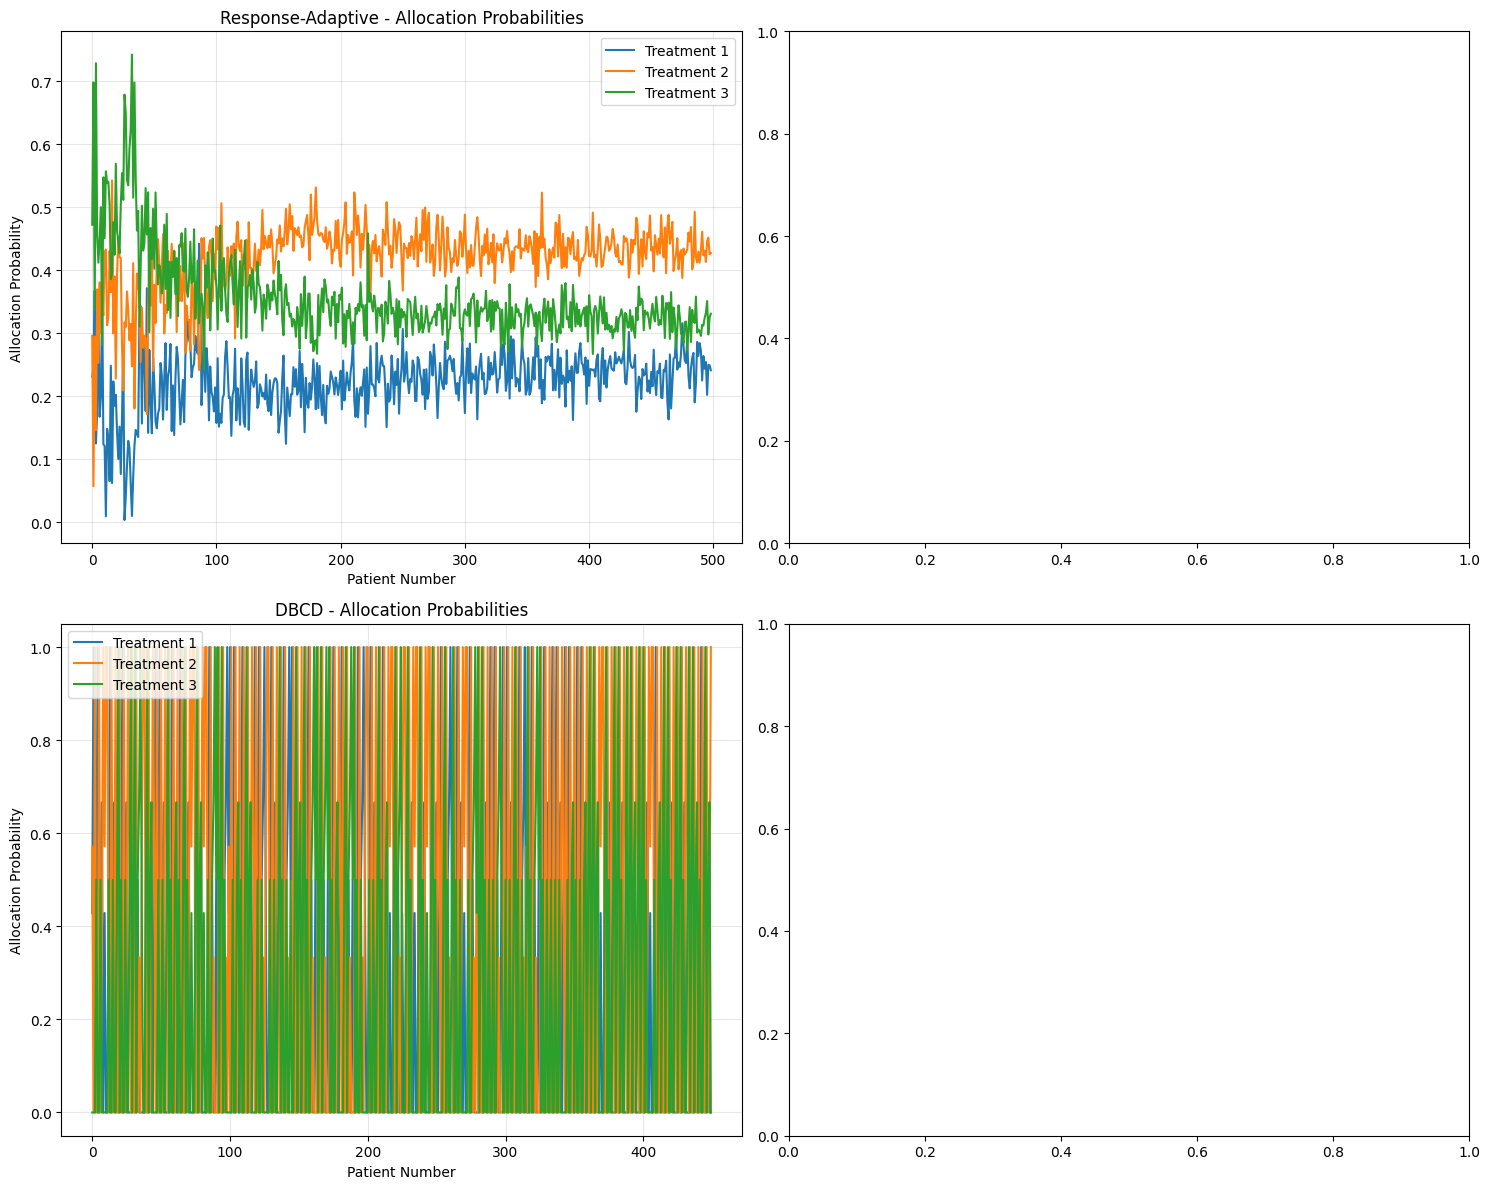

Final Allocation Proportions:
Response-Adaptive: ['0.230', '0.410', '0.360']
Covariate-Adaptive: ['0.762', '0.140', '0.098']
DBCD: ['0.300', '0.400', '0.300']

Observed Success Rates:
Response-Adaptive: ['0.348', '0.634', '0.456']
Covariate-Adaptive: ['0.420', '0.586', '0.469']
DBCD: ['0.407', '0.655', '0.487']


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class AdaptiveRandomization:
    """Base class for adaptive randomization methods"""
    def __init__(self, n_treatments):
        self.n_treatments = n_treatments
        self.reset()

    def reset(self):
        self.outcomes = {i: [] for i in range(self.n_treatments)}
        self.allocations = []
        self.probabilities_history = []

    def update(self, treatment, outcome):
        self.outcomes[treatment].append(outcome)
        self.allocations.append(treatment)

    def get_allocation_probabilities(self):
        raise NotImplementedError

class ResponseAdaptiveRandomization(AdaptiveRandomization):
    """Response-adaptive randomization (RAR) based on success rates"""
    def __init__(self, n_treatments, alpha=1.0, beta=1.0):
        super().__init__(n_treatments)
        self.alpha = alpha  # Beta distribution parameters
        self.beta = beta

    def get_allocation_probabilities(self):
        # Use Beta-Bernoulli conjugate priors
        success_counts = [sum(self.outcomes[i]) for i in range(self.n_treatments)]
        failure_counts = [len(self.outcomes[i]) - success_counts[i]
                         for i in range(self.n_treatments)]

        # If no data yet, use equal probabilities
        if all(len(outcomes) == 0 for outcomes in self.outcomes.values()):
            return np.ones(self.n_treatments) / self.n_treatments

        # Thompson sampling approach
        samples = []
        for i in range(self.n_treatments):
            alpha_post = self.alpha + success_counts[i]
            beta_post = self.beta + failure_counts[i]
            samples.append(np.random.beta(alpha_post, beta_post))

        # Normalize to get probabilities
        probabilities = np.array(samples) / sum(samples)
        self.probabilities_history.append(probabilities)
        return probabilities

class CovariateAdaptiveRandomization(AdaptiveRandomization):
    """Covariate-adaptive randomization to balance covariates"""
    def __init__(self, n_treatments, covariate_levels):
        super().__init__(n_treatments)
        self.covariate_levels = covariate_levels
        self.covariate_counts = {level: {i: 0 for i in range(n_treatments)}
                               for level in covariate_levels}
        self.patient_covariates = []

    def update(self, treatment, outcome, covariate):
        super().update(treatment, outcome)
        self.covariate_counts[covariate][treatment] += 1
        self.patient_covariates.append(covariate)

    def get_allocation_probabilities(self, covariate):
        # Pocock-Simon minimization method
        imbalance_scores = []

        for treatment in range(self.n_treatments):
            # Calculate imbalance if we assign this treatment
            imbalance = 0
            for level in self.covariate_levels:
                counts = list(self.covariate_counts[level].values())
                max_count = max(counts)

                # Add 1 to simulate assigning this treatment
                if level == covariate:
                    test_count = self.covariate_counts[level][treatment] + 1
                else:
                    test_count = self.covariate_counts[level][treatment]

                imbalance += (test_count - max_count) ** 2

            imbalance_scores.append(imbalance)

        # Convert imbalance to probabilities (lower imbalance = higher probability)
        scores = np.array(imbalance_scores)
        # Fix the error here - use np.array_equal instead of == for arrays
        if np.allclose(scores, scores[0]):  # All approximately equal
            return np.ones(self.n_treatments) / self.n_treatments

        # Use Pocock-Simon biased coin approach
        min_imbalance = min(scores)
        optimal_treatments = [i for i, score in enumerate(scores) if abs(score - min_imbalance) < 1e-10]

        probabilities = np.zeros(self.n_treatments)
        p_optimal = 0.75  # Probability of choosing optimal treatment

        if len(optimal_treatments) == 1:
            probabilities[optimal_treatments[0]] = p_optimal
            for i in range(self.n_treatments):
                if i != optimal_treatments[0]:
                    probabilities[i] = (1 - p_optimal) / (self.n_treatments - 1)
        else:
            for i in optimal_treatments:
                probabilities[i] = p_optimal / len(optimal_treatments)
            for i in range(self.n_treatments):
                if i not in optimal_treatments:
                    probabilities[i] = (1 - p_optimal) / (self.n_treatments - len(optimal_treatments))

        return probabilities

class DoubleAdaptiveRandomization(AdaptiveRandomization):
    """DBCD (Doubly-adaptive Biased Coin Design)"""
    def __init__(self, n_treatments, target_allocation=None, gamma=2.0):
        super().__init__(n_treatments)
        self.target_allocation = target_allocation or np.ones(n_treatments) / n_treatments
        self.gamma = gamma

    def get_allocation_probabilities(self):
        if not self.allocations:
            return self.target_allocation

        n_total = len(self.allocations)
        current_proportions = np.array([self.allocations.count(i) / n_total
                                      for i in range(self.n_treatments)])

        # Calculate normalized differences from target
        differences = self.target_allocation - current_proportions

        # DBCD allocation function - fix division by zero
        total_abs_diff = sum(abs(differences))
        if total_abs_diff == 0:
            return self.target_allocation

        allocation_function = lambda d: d / (self.gamma * total_abs_diff)

        probabilities = np.zeros(self.n_treatments)
        for i in range(self.n_treatments):
            if differences[i] > 0:
                probabilities[i] = allocation_function(differences[i])
            else:
                probabilities[i] = 0

        # Normalize
        if sum(probabilities) > 0:
            probabilities = probabilities / sum(probabilities)
        else:
            probabilities = np.ones(self.n_treatments) / self.n_treatments

        self.probabilities_history.append(probabilities)
        return probabilities

def simulate_trial(randomizer, true_success_rates, n_patients, covariates=None):
    """Simulate a clinical trial with adaptive randomization"""
    outcomes = []
    treatments = []

    for i in range(n_patients):
        if isinstance(randomizer, CovariateAdaptiveRandomization):
            covariate = covariates[i] if covariates is not None else np.random.choice(randomizer.covariate_levels)
            probs = randomizer.get_allocation_probabilities(covariate)
        else:
            probs = randomizer.get_allocation_probabilities()

        treatment = np.random.choice(range(randomizer.n_treatments), p=probs)
        outcome = np.random.binomial(1, true_success_rates[treatment])

        if isinstance(randomizer, CovariateAdaptiveRandomization):
            randomizer.update(treatment, outcome, covariate)
        else:
            randomizer.update(treatment, outcome)

        treatments.append(treatment)
        outcomes.append(outcome)

    return treatments, outcomes

def plot_results(randomizers, labels, n_patients):
    """Plot allocation probabilities over time"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (randomizer, label) in enumerate(zip(randomizers, labels)):
        if hasattr(randomizer, 'probabilities_history') and randomizer.probabilities_history:
            probs_history = np.array(randomizer.probabilities_history)

            for treat in range(randomizer.n_treatments):
                axes[i].plot(probs_history[:, treat],
                           label=f'Treatment {treat+1}')

            axes[i].set_xlabel('Patient Number')
            axes[i].set_ylabel('Allocation Probability')
            axes[i].set_title(f'{label} - Allocation Probabilities')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # Set up simulation parameters
    n_treatments = 3
    n_patients = 500
    true_success_rates = [0.4, 0.6, 0.5]  # True success rates for each treatment

    # Initialize different randomization methods
    rar = ResponseAdaptiveRandomization(n_treatments)
    car = CovariateAdaptiveRandomization(n_treatments, ['A', 'B', 'C'])
    dbcd = DoubleAdaptiveRandomization(n_treatments, target_allocation=[0.3, 0.4, 0.3])

    # Generate some covariates for the trial
    covariates = np.random.choice(['A', 'B', 'C'], n_patients)

    # Run simulations
    treatments1, outcomes1 = simulate_trial(rar, true_success_rates, n_patients)
    treatments2, outcomes2 = simulate_trial(car, true_success_rates, n_patients, covariates)
    treatments3, outcomes3 = simulate_trial(dbcd, true_success_rates, n_patients)

    # Plot results
    randomizers = [rar, car, dbcd]
    labels = ['Response-Adaptive', 'Covariate-Adaptive', 'DBCD']
    fig = plot_results(randomizers, labels, n_patients)
    plt.show()

    # Calculate final allocation proportions
    print("Final Allocation Proportions:")
    for randomizer, label in zip(randomizers, labels):
        allocations = randomizer.allocations
        proportions = [allocations.count(i) / len(allocations)
                      for i in range(n_treatments)]
        print(f"{label}: {[f'{p:.3f}' for p in proportions]}")

    # Calculate observed success rates
    print("\nObserved Success Rates:")
    for randomizer, label in zip(randomizers, labels):
        success_rates = []
        for i in range(n_treatments):
            outcomes = randomizer.outcomes[i]
            if outcomes:
                success_rate = sum(outcomes) / len(outcomes)
            else:
                success_rate = 0
            success_rates.append(success_rate)
        print(f"{label}: {[f'{r:.3f}' for r in success_rates]}")